# Configuring Location Tracking and Track Views For Your Organization

<center><img src=" 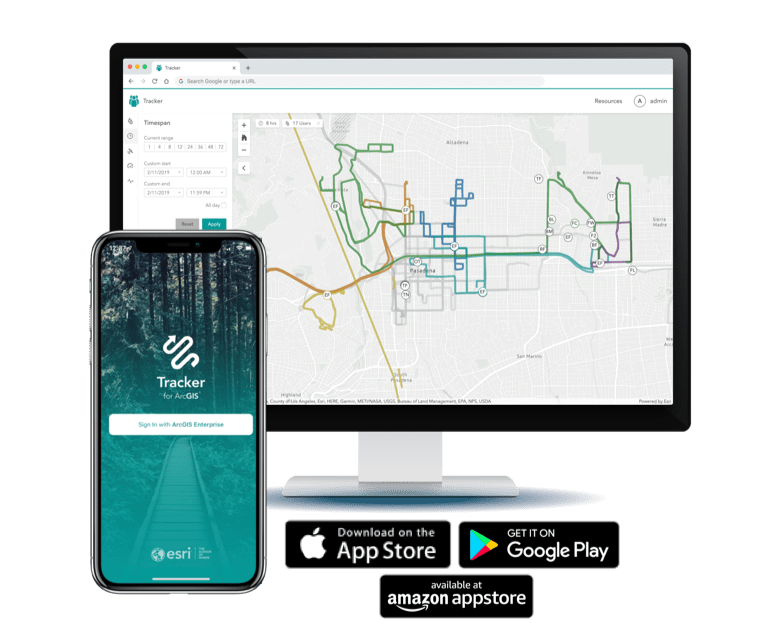" width=500></center>


[Location tracking](https://enterprise.arcgis.com/en/portal/latest/administer/windows/configure-location-tracking.htm) is an organization-wide capability, providing the ability to record where users are and where they have been. Location tracking makes use of a feature service that stores tracked locations as point features in the scalable spatiotemporal big data store. The tracks are secure within the location tracking service: users only see their own tracks, with additional permissions required to view the tracks of others. The tracks can be used for situational awareness and for analysis to answer questions related to where users have been.

[Tracker for ArcGIS](https://www.esri.com/en-us/arcgis/products/tracker-for-arcgis/overview) empowers location tracking, using two apps: the **Track Viewer web app** and the **Tracker for ArcGIS mobile app**. The Track Viewer web app enables administrators to create track views, defining who is tracked and who can view those tracks. The Tracker mobile app is optimized for tracking locations in the field, running in background while minimizing the impact on device battery. The mobile app records tracks whether or not there is a data connection, and gives mobile users control of when they are and aren't tracked.

The ArcGIS API for Python makes it easy to manage location tracking capability in an automated, repeatable, and scalable way.

## Configuring Location Tracking
An authenicated administrator is able to configure location tracking via the `LocationTrackingManager`.

In [1]:
import arcgis

In [2]:
dir(arcgis.apps.tracker)

['LocationTrackingError',
 'LocationTrackingManager',
 'MobileUserManager',
 'TrackView',
 'TrackViewerManager',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_errors',
 '_location_tracking',
 '_track_view']

In [1]:
from arcgis.gis import GIS
from arcgis.apps.tracker import TrackView

gis = GIS(profile="your_enterprise_portal")
location_tracking = gis.admin.location_tracking

Location Tracking has three states `enabled`, `paused`, and `disabled`. It's easy to check the status of Location Tracking.

In [2]:
location_tracking.status

'disabled'

An administrator is able to enable location tracking via the `LocationTrackingManager`.

In [3]:
location_tracking.enable()

True

When location tracking is enabled, a new item gets created representing the `Location Tracking Feature Service`. Any mobile user can upload their tracks to this service. This item can be easily accessed using the `LocationTrackingManager` object.

In [4]:
location_tracking.item

<Item title:"location_tracking" type:Feature Layer Collection owner:apulver>

The `Location Tracking Feature Service` has two layers. The first layer,`tracks`, stores the historical breadcrumbs of each user. The second layer, `last_known_locations`, stores the most recent location of each user that is using the Tracker mobile app. These layers can be easily accessed via the `LocationTrackingManager`.

In [5]:
location_tracking.tracks_layer

<FeatureLayer url:"https://pythonapi.playground.esri.com/server/rest/services/Hosted/location_tracking/FeatureServer/0">

In [6]:
location_tracking.last_known_locations_layer

<FeatureLayer url:"https://pythonapi.playground.esri.com/server/rest/services/Hosted/location_tracking/FeatureServer/1">

By default, the tracks layer has a retention period of 30 days which means tracks will only be stored for 30 days. An administrator is able to configure the retention period to suit their organization's needs. Let's see how to set the retention period to 6 months.

In [7]:
location_tracking.retention_period = 6
location_tracking.retention_period_units = "MONTHS"

Additionally, if an organization wants to keep their tracks forever, the retention period can be turned off.

In [8]:
location_tracking.retention_period_enabled = False

### Creating and Configuring a Track View
A core concept of Location Tracking is that certain users in the organization are able to view the tracks of others. This is accomplished by creating a "Track View". A track view is a [feature service view](https://doc.arcgis.com/en/arcgis-online/manage-data/create-hosted-views.htm) created from the Location Tracking Service. It contains a list of Mobile Users representing the users whose tracks will be displayed, and a list of Track Viewers who will have access to see those users tracks. A Track View can easily be created by an administrator.

In [9]:
track_view = location_tracking.create_track_view("Demo Track View")

The `create_track_view()` function returns a `TrackView` object. An adminstrator can easily add viewers to the `TrackView`:

In [10]:
track_view.viewers.add(['tracker_demo'])

Similarily an administrator can add mobile users to the Track View

In [11]:
track_view.mobile_users.add(['tracker_demo'])

It's easy to see who the track viewers and mobile users are in a `TrackView`

In [12]:
track_view.viewers.list()

['tracker_demo', 'apulver']

In [13]:
track_view.mobile_users.list()

['tracker_demo']

The `TrackView` provides access to both the tracks and last known locations layers so they can easily be used for analysis

In [14]:
track_view.tracks_layer

<FeatureLayer url:"https://pythonapi.playground.esri.com/server/rest/services/Hosted/98bebbeb4dcf4bbc942c24c2595fabc2_Track_View/FeatureServer/0">

In [15]:
track_view.last_known_locations_layer

<FeatureLayer url:"https://pythonapi.playground.esri.com/server/rest/services/Hosted/98bebbeb4dcf4bbc942c24c2595fabc2_Track_View/FeatureServer/1">

Track views can easily be searched for as follows:

In [16]:
items = gis.content.search("typekeywords:'Location Tracking View'")

A `TrackView` object can be created from an item as follows:

In [17]:
track_view2 = TrackView(items[0])
track_view2

### Managing Tracker Licenses

In order to sign into the Tracker mobile app and upload tracks, users must be provisioned a [Tracker for ArcGIS](https://www.esri.com/en-us/arcgis/products/tracker-for-arcgis/overview) License.

We can see how many licenses are available and how many are assigned

In [18]:
tracker_license = gis.admin.license.get('Tracker for ArcGIS')
tracker_license.report

,Entitlement,Total,Assigned,Remaining
0,tracker,50,0,50


A Tracker for ArcGIS License can be assigned as follows

In [19]:
tracker_license.assign(username='tracker_demo', entitlements=["tracker"])

True

Similarily a license could be revoked

In [20]:
tracker_license.revoke(username='tracker_demo', entitlements=["tracker"])

True

### Managing the "view location tracks" privilege

In order for track viewers to see the tracks of other users in the organization (through a Track View), they must have a role that has the "view location tracks" privilege. The administrator role has this privilege by default. Non-administrators will need to be assigned a custom role that has this privilege. A custom role that can view tracks can be created as shown below.

In [21]:
track_viewer_role = gis.users.roles.create(
    name='Track Viewer',
    description="A user that can use the Track Viewer web app to see others tracks",
    privileges=[
        "portal:user:joinGroup",
        "portal:user:viewTracks",
    ]
)

The custom role can then be assigned to a user.

In [22]:
user = gis.users.get('tracker_demo')
user.update_role(track_viewer_role)

True

## Conclusion
This guide explains how an administrator can enable the location tracking capability, and once enabled, how track views can be created and users be added to it. It also explains how an administrator can assign licenses for the Tracker field app to desired users and how custom roles with privileges to view tracks of other users be created.